You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import os
import pandas as pd
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from NGD_TK_AS import NGD2L_TK_AS

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from NGD_TK_AS.ipynb


# Load Experimental data

## select files and channels

In [3]:
loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGD2LASpara.npz', allow_pickle=True)

-0.007096342185162675


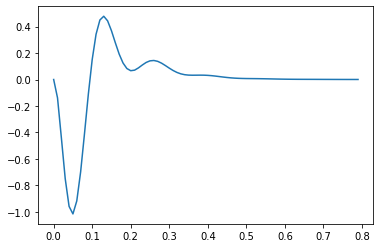

In [4]:
cn = 53
dt = 0.01
TKtaxis = np.arange(0,0.8,dt)
TK = NGD2L_TK_AS(TKtaxis, *pd.DataFrame(loadfiles['para_dict'][()]).loc[cn-1][:-1])
plt.plot(TKtaxis, TK)
longTK = np.append(np.zeros(len(TK)-1), TK)
print(sum(TK)*dt)

In [5]:
# loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGDSpara.npz', allow_pickle=True)

In [6]:
Fc_list = [2,4,7,10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]

x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

In [7]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)) 
t_cor_list

[0.534, 0.432, 0.405, 0.395]

In [8]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]

# Real Spike

0.14000000000001478
0.05000000000001137
0.009999999999990905
-0.030000000000001137


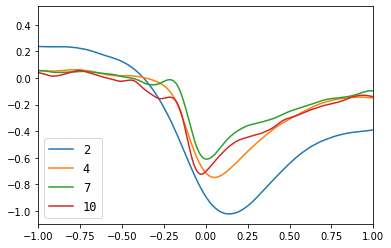

In [9]:
expXcorr_list = [0]*len(x_list)

for i in range(len(x_list)):
    expXcorr_list[i] = np.correlate(x_list[i], rstate_list[i], 'same')/np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same')
    Taxis = T_list[i]-T_list[i][int(len(T_list[i])/2)]
    plt.plot(Taxis, expXcorr_list[i])
    print(Taxis[np.argmin(expXcorr_list[i])])
    
plt.xlim([-1, 1])
plt.legend( Fc_list , loc='best', prop={'size': 'large', 'family': 'monospace'})

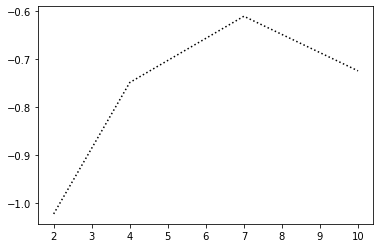

In [10]:
plt.plot(Fc_list, [min(expXcorr_list[i]) for i in range(len(x_list))], 'k:')

# Fake Spike from TK

In [11]:
fr_list = [np.convolve(x*2+10, longTK , 'same')*dt for x in x_list]

(150, 160)

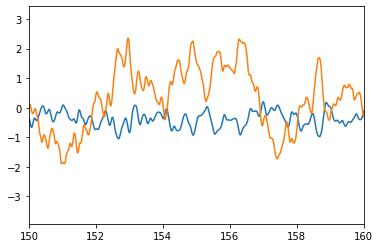

In [12]:
i = 3
plt.plot(T_list[i], 5*fr_list[i])
plt.plot(T_list[i], x_list[i])
plt.xlim([150, 160])

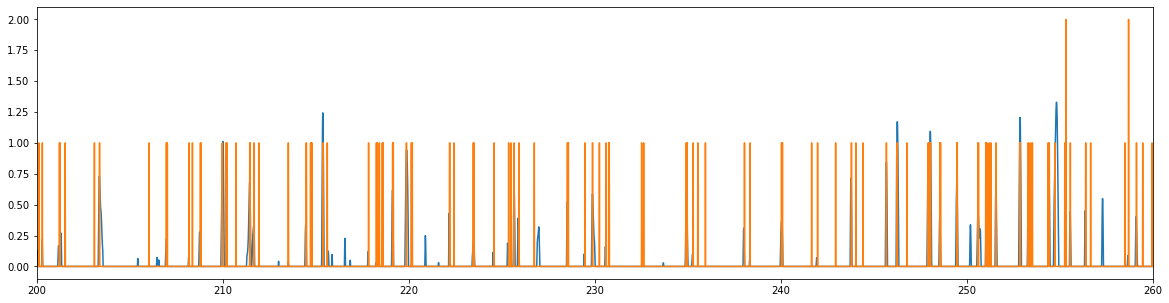

In [13]:
plt.plot(T_list[i], 15*NL(fr_list[i],0))
plt.plot(T_list[i], rstate_list[i])
plt.xlim([200, 260])
plt.gcf().set_size_inches(20, 5)

-0.07115798079202765


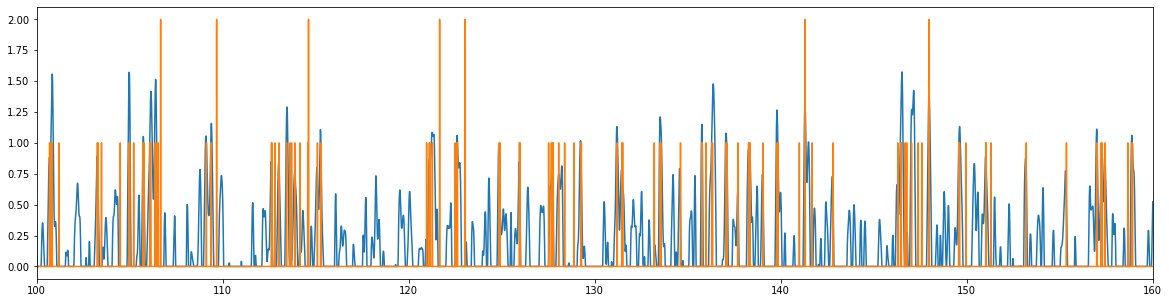

In [14]:
plt.plot(T_list[i], 10*NL(fr_list[i],np.mean(fr_list[i])))
print(np.mean(fr_list[i]))
plt.plot(T_list[i], rstate_list[i])
plt.xlim([100, 160])
plt.gcf().set_size_inches(20, 5)

## Threshold

-0.01019001440316869 1.5169945026118026
-0.007970308962758299 1.285719677333846
-0.008039659479735284 1.1703577583525575
0.030934555696558563 1.8241466467982617


Text(0.5, 0, 'centered-normalized threshold')

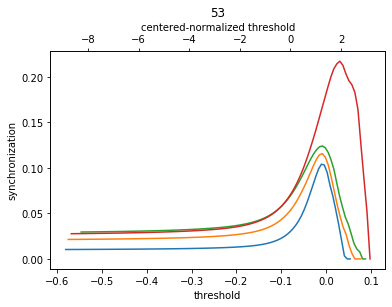

In [15]:
for i in range(len(x_list)):
    thetas = np.linspace(min(fr_list[i]), max(fr_list[i]), 100, endpoint = False)
    sync = [sum(rstate_list[i]*NL(fr_list[i],theta)/sum(NL(fr_list[i],theta))) for theta in thetas]
    plt.plot(thetas, sync)
#     ncfc = (fr_list[i]-np.mean(fr_list[i]))/np.std(fr_list[i])
    print(thetas[np.argmax(sync)], (thetas[np.argmax(sync)]-np.mean(fr_list[i]))/np.std(fr_list[i]))
    
plt.title(str(cn))
plt.xlabel('threshold')
plt.ylabel('synchronization')

ax2 = plt.gca().twiny()
ncfc = (fr_list[i]-np.mean(fr_list[i]))/np.std(fr_list[i])
ax2.plot(np.linspace(min(ncfc), max(ncfc), 100), np.zeros(100)) # Create a dummy plot
ax2.lines = []
ax2.set_xlabel('centered-normalized threshold')

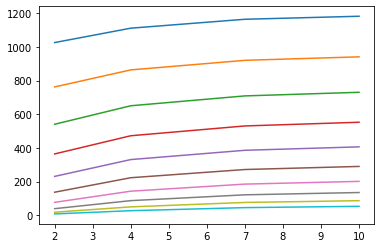

In [16]:
for theta in np.linspace(-0.1, 0.01, 10):
    plt.plot(Fc_list, [sum(NL(fr,theta)) for fr in fr_list])

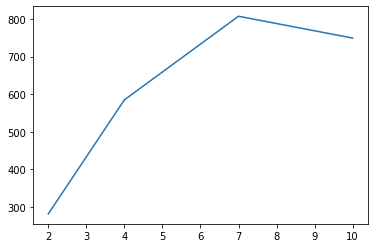

In [17]:
plt.plot(Fc_list, [sum(rstate) for rstate in rstate_list])

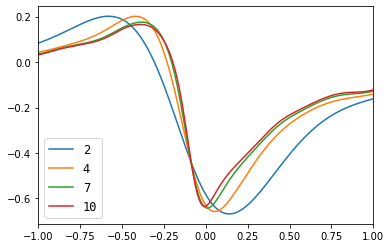

In [18]:
i = 0
for i in range(len(x_list)):
    plt.plot(T_list[i]-T_list[i][int(len(T_list[i])/2)], np.correlate(x_list[i], NL(fr_list[i],-0.1), 'same')
                                                        /np.correlate(np.ones_like(x_list[i]), NL(fr_list[i],-0.1), 'same'))

    
plt.xlim([-1, 1])
plt.legend( Fc_list , loc='best', prop={'size': 'large', 'family': 'monospace'})

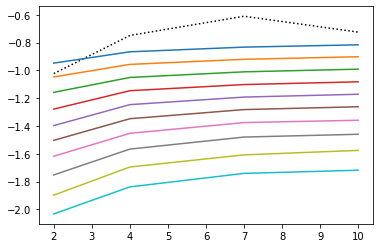

In [19]:
plt.plot(Fc_list, [min(expXcorr) for expXcorr in expXcorr_list], 'k:')
for nctheta in np.linspace(0, 2, 10):
    Xcorr_list = [0]*len(x_list)
    for i in range(len(x_list)):
        ncfc = (fr_list[i]-np.mean(fr_list[i]))/np.std(fr_list[i])
        Xcorr_list[i] = np.correlate(x_list[i],NL(ncfc, nctheta), 'same')   \
                        /np.correlate(np.ones_like(x_list[i]), NL(ncfc, nctheta), 'same')
    plt.plot(Fc_list, [min(Xcorr) for Xcorr in Xcorr_list])

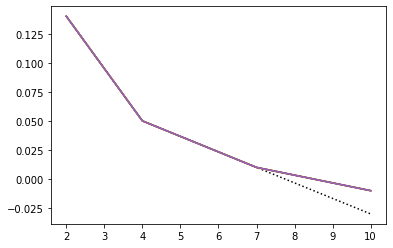

In [20]:
Preceed = []
for i in range(len(x_list)):
    Taxis = T_list[i]-T_list[i][int(len(T_list[i])/2)]
    Preceed.append(Taxis[np.argmin(expXcorr_list[i])])
plt.plot(Fc_list, Preceed, 'k:')
for theta in np.linspace(-0.1, 0.01, 5):
    Xcorr_list = [0]*len(x_list)
    Preceed = []
    for i in range(len(x_list)):
        Taxis = T_list[i]-T_list[i][int(len(T_list[i])/2)]
        Xcorr_list[i] = np.correlate(x_list[i],NL(fr_list[i], theta), 'same')   \
                        /np.correlate(np.ones_like(x_list[i]), NL(fr_list[i], theta), 'same')
        Preceed.append(Taxis[np.argmin(Xcorr_list[i])])
    plt.plot(Fc_list, Preceed)